In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [7]:
dataset = pd.read_csv('abcnews.csv')

In [18]:
print(dataset.shape)
print(dataset.isna().sum())
dataset.head()

(10000, 2)
publish_date     0
headline_text    0
dtype: int64


In [76]:
dataset['headline_text'][0]

'aba decides against community broadcasting licence'

In [77]:
docs = dataset['headline_text'].str.lower()
special_char = re.findall(r'[^a-z0-9 ]', ' '.join(docs))

## Removing numerical values
# re.sub(r'[0-9]+','number', docs)
# pd.Series(re.findall(r'\d+', ' '.join(docs))).value_counts()

docs = docs.str.replace(r'\d+','')

In [78]:
from nltk.corpus import stopwords
common_stop_words = stopwords.words('english')

docs = docs.apply(lambda x: ' '.join(x for x in x.split(' ') if x not in common_stop_words))

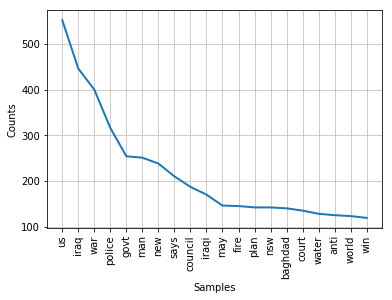

In [93]:
# words = nltk.word_tokenize(' '.join(docs))
words = pd.Series(' '.join(docs).split())
nltk.FreqDist(words).plot(20)

In [268]:
## Corpus Building
corpus_gensim = []
corpus_sklearn = []
tokens = []

from nltk.stem import PorterStemmer, WordNetLemmatizer
custom_stop_words = []

stop_words = np.hstack([common_stop_words, custom_stop_words])

stemmer = PorterStemmer()
lemma =WordNetLemmatizer()

for doc in docs:
    words = doc.split(' ')
    words_clean = [stemmer.stem(lemma.lemmatize(word)) for word in words if word not in stop_words and len(word) > 3]
    corpus_gensim.append(words_clean)
    tokens.extend(words_clean)
    corpus_sklearn.append(' '.join(words_clean))
    
# len(nltk.FreqDist([stemmer.stem(word) for word in words if word not in stop_words]))

In [269]:
## DTM matrix using corpus_sklearn
dtm_model = CountVectorizer()
dtm= dtm_model.fit_transform(corpus_sklearn)
df_dtm = pd.DataFrame(dtm.toarray(), columns=dtm_model.get_feature_names())
print(df_dtm.shape)
df_dtm.head()

(10000, 6651)


abalon  abandon  abar  abattoir  abbott  abdic  abduct  abid  abigroup  \
0       0        0     0         0       0      0       0     0         0   
1       0        0     0         0       0      0       0     0         0   
2       0        0     0         0       0      0       0     0         0   
3       0        0     0         0       0      0       0     0         0   
4       0        0     0         0       0      0       0     0         0   

   abil   ...    zeehan  zellweg  zidan  zieg  zimbabw  zimbabwean  zimmerman  \
0     0   ...         0        0      0     0        0           0          0   
1     0   ...         0        0      0     0        0           0          0   
2     0   ...         0        0      0     0        0           0          0   
3     0   ...         0        0      0     0        0           0          0   
4     0   ...         0        0      0     0        0           0          0   

   zone  zoo  zurich  
0     0    0       0  
1     0    0       0  
2     0    0       0  
3     0    0       0  
4     0    0       0  

[5 rows x 6651 columns]

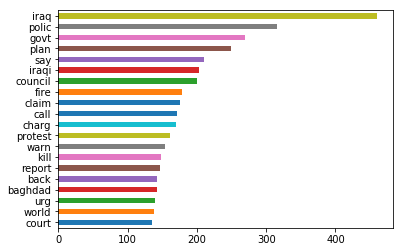

In [270]:
top_words = df_dtm.sum().sort_values(ascending = False).head(20)
top_words[::-1].plot.barh()

## Using gensim package

In [276]:
from gensim import models, corpora
dictionary = corpora.Dictionary(corpus_gensim)
comp_corpus_gensim = [dictionary.doc2bow(doc) for doc in corpus_gensim]
comp_corpus_gensim[:3]

[[(0, 1), (1, 1), (2, 1), (3, 1)],
 [(4, 1), (5, 1), (6, 1), (7, 1), (8, 1)],
 [(9, 1), (10, 1), (11, 1), (12, 1)]]

In [277]:
corpus_gensim[312]

['lend', 'leas', 'post', 'million', 'loss']

In [272]:
dict_tokens = []
for i in range(len(dictionary)):
    dict_tokens.append(dictionary.get(i))
    
dict_tokens[:5]   

['broadcast', 'commun', 'decid', 'licenc', 'awar']

In [273]:
## Identfying top words using gensim package
word_list = []
for i in range(len(comp_corpus_gensim)):
    for j in range(len(comp_corpus_gensim[i])):
        if dictionary.get(comp_corpus_gensim[i][j][0]) in dict_tokens:
            word_list.append(dictionary.get(comp_corpus_gensim[i][j][0]))
            
word_count = pd.Series(' '.join(word_list).split()).value_counts() 

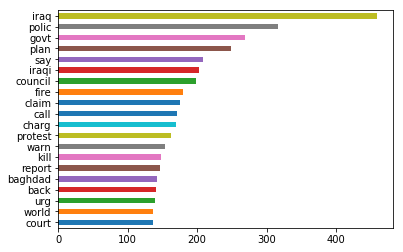

In [274]:
word_count.sort_values(ascending=False).head(20)[::-1].plot.barh()

In [297]:
from gensim import corpora, models

tfidf = models.TfidfModel(comp_corpus_gensim)
tfidf_corpus_gensim = tfidf[comp_corpus_gensim]
tfidf_corpus_gensim[0]

[(0, 1), (1, 1), (2, 1), (3, 1)]

## Topic Modelling

In [298]:
LDA_model = models.LdaMulticore(comp_corpus_gensim, num_topics = 10, id2word = dictionary, passes=3, workers=2)
for idx, topic in LDA_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.010*"baghdad" + 0.009*"iraq" + 0.009*"iraqi" + 0.007*"nation" + 0.006*"urg" + 0.006*"bomb" + 0.006*"troop" + 0.006*"call" + 0.005*"claim" + 0.005*"govt"
Topic: 1 
Words: 0.017*"iraq" + 0.009*"world" + 0.009*"back" + 0.008*"forc" + 0.008*"face" + 0.007*"north" + 0.006*"clash" + 0.005*"fund" + 0.005*"water" + 0.005*"stay"
Topic: 2 
Words: 0.020*"iraq" + 0.018*"iraqi" + 0.018*"kill" + 0.011*"fire" + 0.010*"sar" + 0.010*"troop" + 0.008*"baghdad" + 0.008*"say" + 0.008*"soldier" + 0.008*"attack"
Topic: 3 
Words: 0.011*"iraq" + 0.010*"plan" + 0.008*"sar" + 0.008*"fire" + 0.007*"australia" + 0.007*"say" + 0.007*"anti" + 0.007*"protest" + 0.005*"govt" + 0.005*"race"
Topic: 4 
Words: 0.011*"fire" + 0.008*"iraqi" + 0.008*"death" + 0.007*"howard" + 0.007*"accid" + 0.006*"iraq" + 0.005*"saddam" + 0.005*"dead" + 0.005*"suicid" + 0.005*"report"
Topic: 5 
Words: 0.013*"council" + 0.011*"face" + 0.009*"report" + 0.009*"charg" + 0.009*"concern" + 0.008*"court" + 0.008*"baghdad" + 0.00

In [299]:
LDA_model_tfidf = models.LdaMulticore(tfidf_corpus_gensim, num_topics = 10, id2word = dictionary, passes = 2, workers =4)
for idx, topic in LDA_model_tfidf.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.007*"troop" + 0.005*"baghdad" + 0.005*"call" + 0.005*"anti" + 0.005*"iraq" + 0.004*"australian" + 0.004*"protest" + 0.004*"melbourn" + 0.004*"say" + 0.004*"explos"
Topic: 1 
Words: 0.005*"iraqi" + 0.004*"strike" + 0.004*"plan" + 0.004*"help" + 0.003*"union" + 0.003*"attack" + 0.003*"opposit" + 0.003*"iraq" + 0.003*"meet" + 0.003*"report"
Topic: 2 
Words: 0.006*"iraq" + 0.004*"urg" + 0.004*"protest" + 0.004*"iraqi" + 0.004*"baghdad" + 0.003*"govt" + 0.003*"march" + 0.003*"anti" + 0.003*"show" + 0.003*"control"
Topic: 3 
Words: 0.006*"iraq" + 0.006*"baghdad" + 0.006*"iraqi" + 0.006*"kill" + 0.005*"fire" + 0.005*"death" + 0.004*"attack" + 0.004*"british" + 0.004*"missil" + 0.004*"soldier"
Topic: 4 
Words: 0.006*"charg" + 0.004*"polic" + 0.003*"hope" + 0.003*"kill" + 0.003*"face" + 0.003*"industri" + 0.003*"stab" + 0.003*"iraq" + 0.003*"court" + 0.003*"defend"
Topic: 5 
Words: 0.007*"iraq" + 0.005*"say" + 0.005*"council" + 0.004*"warn" + 0.004*"polic" + 0.004*"fire" + 0.

In [307]:
print(corpus_gensim[3418])
for index, score in sorted(LDA_model[comp_corpus_gensim[3418]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, LDA_model.print_topic(index, 10)))

['woman', 'dead', 'child', 'injur', 'accid']

Score: 0.562709629535675	 
Topic: 0.011*"fire" + 0.008*"iraqi" + 0.008*"death" + 0.007*"howard" + 0.007*"accid" + 0.006*"iraq" + 0.005*"saddam" + 0.005*"dead" + 0.005*"suicid" + 0.005*"report"

Score: 0.3039313852787018	 
Topic: 0.015*"polic" + 0.014*"govt" + 0.009*"group" + 0.008*"charg" + 0.007*"claim" + 0.007*"baghdad" + 0.006*"iraq" + 0.006*"defend" + 0.006*"test" + 0.006*"back"

Score: 0.01667233556509018	 
Topic: 0.020*"iraq" + 0.018*"iraqi" + 0.018*"kill" + 0.011*"fire" + 0.010*"sar" + 0.010*"troop" + 0.008*"baghdad" + 0.008*"say" + 0.008*"soldier" + 0.008*"attack"

Score: 0.016671104356646538	 
Topic: 0.010*"govt" + 0.009*"world" + 0.008*"claim" + 0.006*"say" + 0.005*"plan" + 0.005*"woman" + 0.005*"death" + 0.005*"pneumonia" + 0.005*"take" + 0.004*"famili"

Score: 0.01667105406522751	 
Topic: 0.013*"council" + 0.011*"face" + 0.009*"report" + 0.009*"charg" + 0.009*"concern" + 0.008*"court" + 0.008*"baghdad" + 0.008*"warn" + 0.007*"he

In [306]:
print(corpus_gensim[3418])
for index, score in sorted(LDA_model_tfidf[comp_corpus_gensim[3418]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, LDA_model_tfidf.print_topic(index, 10)))

['woman', 'dead', 'child', 'injur', 'accid']

Score: 0.8499558568000793	 
Topic: 0.005*"polic" + 0.004*"name" + 0.003*"hope" + 0.003*"well" + 0.003*"mine" + 0.003*"make" + 0.003*"continu" + 0.003*"iraqi" + 0.003*"miss" + 0.003*"final"

Score: 0.016674665734171867	 
Topic: 0.005*"crash" + 0.005*"protest" + 0.004*"iraq" + 0.004*"bomb" + 0.004*"iraqi" + 0.004*"take" + 0.004*"saddam" + 0.003*"woman" + 0.003*"world" + 0.003*"plane"

Score: 0.0166728924959898	 
Topic: 0.006*"iraq" + 0.006*"baghdad" + 0.006*"iraqi" + 0.006*"kill" + 0.005*"fire" + 0.005*"death" + 0.004*"attack" + 0.004*"british" + 0.004*"missil" + 0.004*"soldier"

Score: 0.016672596335411072	 
Topic: 0.006*"charg" + 0.004*"polic" + 0.003*"hope" + 0.003*"kill" + 0.003*"face" + 0.003*"industri" + 0.003*"stab" + 0.003*"iraq" + 0.003*"court" + 0.003*"defend"

Score: 0.01667218655347824	 
Topic: 0.005*"iraqi" + 0.004*"strike" + 0.004*"plan" + 0.004*"help" + 0.003*"union" + 0.003*"attack" + 0.003*"opposit" + 0.003*"iraq" + 0.003*"me

In [308]:
## Get the best topic based on probabilities
def get_best_topic(d2t):
    best_topic = pd.DataFrame(d2t,
                             columns = ['Topic','Prob']
                             ).sort_values(by='Prob', ascending = False)['Topic'].values[0]
    return best_topic

dataset['Topic'] = [get_best_topic(LDA_model.get_document_topics(comp_corpus_gensim[i])) for i in range(len(comp_corpus_gensim))]

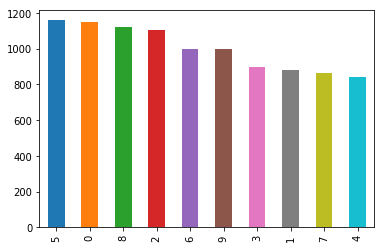

In [309]:
dataset['Topic'].value_counts().plot.bar()